# Лабораторна робота №4 

**Мета:** удосконалити інтелектуального агента-автомобіля з попередньої лабораторної роботи – додати йому систему контролю швидкості на основі згорткової нейронної мережі. Отримати практичні навички роботи з нейронними мережами та вирішення проблеми класифікації зображень.  

**Завдання:**
1. Отримати базові навички роботи з нейронними мережами.
2. Отримати досвід вирішення проблеми класифікації зображень.
3. Удосконалити агента-автомобіля з попередньої лабораторної роботи.


## 1. Імпорт необхідних бібліотек

In [24]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import os
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from matplotlib.animation import FuncAnimation
from lab1_sl import RoadGraph
from IPython.display import Image, display

## 2. Реалізація підсистеми розпізнавання (Speed CNN)
Цей модуль відповідає за імітацію розпізнавання дорожніх знаків.

### Підготовка даних
Використовується датасет MNIST. Відбираються лише цифри 2-9.

Вхідні дані: Зображення 28x28 .

Вихідні дані: Обмеження швидкості (цифра * 10 км/год).


In [25]:
# Глобальні змінні
GLOBAL_MODEL = None
SIMULATION_IMAGES = {}
VALID_DIGITS = np.arange(2, 10)

def prepare_and_train_cnn():
    # Завантаження даних
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # Створення масок для фільтрації
    train_mask = np.isin(y_train, VALID_DIGITS)
    test_mask = np.isin(y_test, VALID_DIGITS)

    x_train, y_train = x_train[train_mask], y_train[train_mask]
    x_test, y_test = x_test[test_mask], y_test[test_mask]

    # Перетворення та нормалізація
    x_train = np.expand_dims(x_train.astype('float32') / 255.0, -1)
    x_test = np.expand_dims(x_test.astype('float32') / 255.0, -1)

    # Зсув:(Всього 8 класів)
    y_train_shifted = y_train - 2
    y_test_shifted = y_test - 2

    y_train_cat = to_categorical(y_train_shifted, num_classes=8)
    y_test_cat = to_categorical(y_test_shifted, num_classes=8)

    # Архітектура моделі
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(100, activation='relu'),
        Dense(8, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


    # Тренування моделі
    model.fit(x_train, y_train_cat, epochs=5, batch_size=32, validation_data=(x_test, y_test_cat), verbose=1)

    # Завантаження
    model.save("speed_sign_cnn.h5")
    print(f"Модель успішно збережена як speed_sign_cnn.h5")

    return model


# Завантажує та зберігає зображення знаків (цифр 2-9) для симуляції
def load_sign_images():
    global SIMULATION_IMAGES
    (x_train, y_train), _ = mnist.load_data()
    x_train = np.expand_dims(x_train.astype('float32') / 255.0, -1)

    for digit in VALID_DIGITS:
        SIMULATION_IMAGES[digit] = x_train[y_train == digit]

# Повертає випадкове зображення цифри для симуляції камери
def get_sign_image(digit_value):
    if digit_value not in SIMULATION_IMAGES or not SIMULATION_IMAGES:
        load_sign_images()

    if digit_value not in SIMULATION_IMAGES:
        raise ValueError(f"Цифра {digit_value} не підтримується як знак.")

    # Вибираємо випадкове зображення цієї цифри
    images = SIMULATION_IMAGES[digit_value]
    return random.choice(images)

#Завантажує або повертає збережену модель CNN
def get_cnn_model():
    global GLOBAL_MODEL

    if GLOBAL_MODEL is None:
        if not os.path.exists("speed_sign_cnn.h5"):
            print("Модель CNN не знайдена. Запуск тренування")
            GLOBAL_MODEL = prepare_and_train_cnn()
        else:
            print(f"Завантаження збереженої моделі CNN з speed_sign_cnn.h5")
            GLOBAL_MODEL = load_model("speed_sign_cnn.h5")

    return GLOBAL_MODEL

# Приймає зображення знака, повертає визначену швидкість (20-90 км/год)
def recognize_sign(image_data):
    model = get_cnn_model()
    # Форматування вхідних даних
    input_data = np.expand_dims(image_data, 0)
    # Прогноз
    predictions = model.predict(input_data, verbose=0)
    # Отримання (0..7)
    predicted_class = np.argmax(predictions[0])
    # Зворотний зсув
    predicted_digit = predicted_class + 2

    return predicted_digit * 10

# Ініціалізація моделі при запуску комірки
_ = get_cnn_model()
load_sign_images()

Завантаження збереженої моделі CNN з speed_sign_cnn.h5


## 3. Алгоритм роботи агента
Агент рухається в об'єкті RoadGraph. Логіка прийняття рішень:
1. (perceive): Визначає сусідні перехрестя.
2. (set_speed): Перед рухом до сусіда агент "дивиться" на знак (атрибут ребра), передає його зображення в CNN і отримує обмеження швидкості.
3. (decide_next): Використовує DFS (пошук в глибину) з евристикою Манхеттенської відстані (обирає сусіда, геометрично найближчого до фінішу).
4. Використовує стек для повернення назад у разі тупика.

In [26]:
class KnowledgeBase:
    def __init__(self):
        self.world = {}

    def tell(self, node, neighbors):
        if node not in self.world:
            self.world[node] = list(neighbors)

    def ask(self, node):
        return self.world.get(node, [])


class CarAgent:
    def __init__(self, graph: nx.Graph, start: int, finish: int):
        self.graph = graph
        self.start = start
        self.finish = finish
        self.current_node = start
        self.visited = {start}
        self.history = [start]
        self.stack = [start]
        self.kb = KnowledgeBase()
        self.positions = nx.get_node_attributes(graph, 'pos')

        self.speed_history = []

        get_cnn_model()
        load_sign_images()

        self.kb.tell(start, self.perceive())

    def perceive(self):
        return list(self.graph.neighbors(self.current_node))

    def manhattan_distance(self, node1, node2):
        x1, y1 = self.positions[node1]
        x2, y2 = self.positions[node2]
        return abs(x1 - x2) + abs(y1 - y2)

    def set_speed(self, from_node, to_node):
        edge_data = self.graph.get_edge_data(from_node, to_node)
        sign_digit = edge_data.get('speed_limit', self.graph.get_edge_data(to_node, from_node).get('speed_limit'))

        if sign_digit is None:
            return 0

        simulated_image = get_sign_image(sign_digit)

        recognized_speed = recognize_sign(simulated_image)

        return recognized_speed

    def decide_next(self):
        known_neighbors = self.kb.ask(self.current_node)
        if not known_neighbors:
            return None

        unvisited = [n for n in known_neighbors if n not in self.visited]

        if unvisited:
            return min(unvisited, key=lambda n: self.manhattan_distance(n, self.finish))
        else:
            return None

    def move(self):
        next_node = self.decide_next()

        if next_node is not None:
            max_speed = self.set_speed(self.current_node, next_node)
            self.speed_history.append((self.current_node, next_node, max_speed))

            self.current_node = next_node
            self.visited.add(next_node)
            self.history.append(next_node)
            self.stack.append(next_node)
            self.kb.tell(next_node, self.perceive())

        else:
            if len(self.stack) > 1:
                self.stack.pop()
                self.current_node = self.stack[-1]
                self.history.append(self.current_node)

    def get_colors(self):
        colors = []
        for node in self.graph.nodes():
            if node == self.start: colors.append("green")
            elif node == self.current_node: colors.append("blue")
            elif node == self.finish: colors.append("gold")
            elif node in self.visited: colors.append("lightgrey")
            else: colors.append("white")
        return colors

Нижче наведено анімацію руху агента. Червоним кольором позначено шлях. На ребрах підписані реальні обмеження швидкості, а в консоль після завершення виводиться розпізнана швидкість.

C:\Users\Stas\AppData\Local\Temp\ipykernel_4348\1358742509.py:21: UserWarning: frames=<function simulation_generator at 0x0000014AD5678AE0> which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, update, frames=simulation_generator, interval=500, repeat=False)


Пройдений шлях: [0, 1, 0, 5, 6, 7, 12, 17, 18, 19, 24]

Швидкість, встановлена агентом на кожному відрізку:
    Дорога (0 --> 1): 50 км/год
    Дорога (0 --> 5): 20 км/год
    Дорога (5 --> 6): 20 км/год
    Дорога (6 --> 7): 20 км/год
    Дорога (7 --> 12): 90 км/год
    Дорога (12 --> 17): 60 км/год
    Дорога (17 --> 18): 70 км/год
    Дорога (18 --> 19): 30 км/год
    Дорога (19 --> 24): 40 км/год


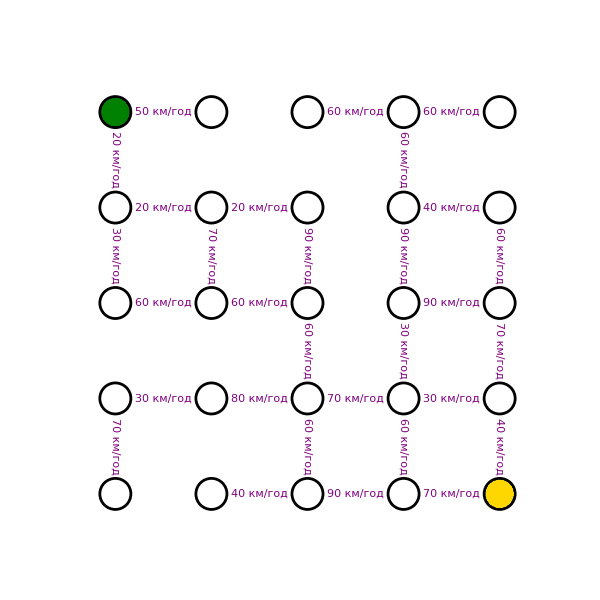

In [27]:
road = RoadGraph(size=25, remove_edges=10)
start, goal = 0, 24
agent = CarAgent(road.graph, start, goal)

fig, ax = plt.subplots(figsize=(6, 6))

def simulation_generator():
    frame = 0
    while agent.current_node != agent.finish and frame < 100:
        yield frame
        frame += 1
    yield frame 

def update(frame):
    ax.clear()
    if frame > 0 and agent.current_node != agent.finish:
        agent.move()
    
    draw_graph(agent, ax)

ani = FuncAnimation(fig, update, frames=simulation_generator, interval=500, repeat=False)

ani.save("lab4_animation.gif", writer='pillow', fps=2)
plt.close()

print(f"Пройдений шлях: {agent.history}\n")
print("Швидкість, встановлена агентом на кожному відрізку:")
for a, b, speed in agent.speed_history:
    print(f"    Дорога ({a} --> {b}): {speed} км/год")

display(Image(filename="lab4_animation.gif"))